# Proyecto detección de tumores cerebrales


Importar dataset desde kaggle:

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets list

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

MessageError: ignored

In [ ]:
!mkdir '/content/drive/My Drive/Colab Notebooks/db/'

In [ ]:
!unzip brain-tumor-classification-mri.zip -d '/content/drive/My Drive/Colab Notebooks/db/'

Con los datos ya cargados porcedemos al desarrollo del código

Importar librerias

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output

In [ ]:
#para importar las imagenes
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_img = []
train_labels = []

test_img = []
test_labels = []

path_train = ('/content/drive/MyDrive/Colab Notebooks/db/Training/')
path_test = ('/content/drive/MyDrive/Colab Notebooks/db/Testing/')

for i in os.listdir(path_train):
    for j in os.listdir(path_train+i):
        train_img.append (cv2.resize(cv2.imread(path_train+i+'/'+j), (28,28)))
        train_labels.append(i)

for i in os.listdir(path_test):
    for j in os.listdir(path_test+i):
        test_img.append (cv2.resize(cv2.imread(path_test+i+'/'+j), (28,28)))
        test_labels.append(i)

In [ ]:
train_img = (np.array(train_img))
test_img = (np.array(test_img))

#etiqueta de labels
train_labels_encoded = [0 if category == 'no_tumor' else(1 if category == 'glioma_tumor' else(2 if category=='meningioma_tumor' else 3)) for category in list(train_labels)]
test_labels_encoded = [0 if category == 'no_tumor' else(1 if category == 'glioma_tumor' else(2 if category=='meningioma_tumor' else 3)) for category in list(test_labels)]

print("Shape of train: ",(train_img).shape," and shape of test: ", (test_img).shape)

Shape of train:  (2870, 28, 28, 3)  and shape of test:  (394, 28, 28, 3)


Revisar la cantidad de datos que tiene el dataset, se graficarán la cantidad de los datos y se ve si debemos realizar aumento de datos

In [ ]:
img_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

img_datagen.fit(train_img)
img_datagen.fit(test_img)

print("Shape of train: ",(train_img).shape," and shape of test: ", (test_img).shape)

Shape of train:  (2870, 28, 28, 3)  and shape of test:  (394, 28, 28, 3)


In [ ]:
train_x, val_x, train_y, val_y = train_test_split(np.array(train_img), np.array(train_labels), test_size = 0.1)
train_x.shape, train_y.shape, val_x.shape, val_y.shape

((2583, 28, 28, 3), (2583,), (287, 28, 28, 3), (287,))

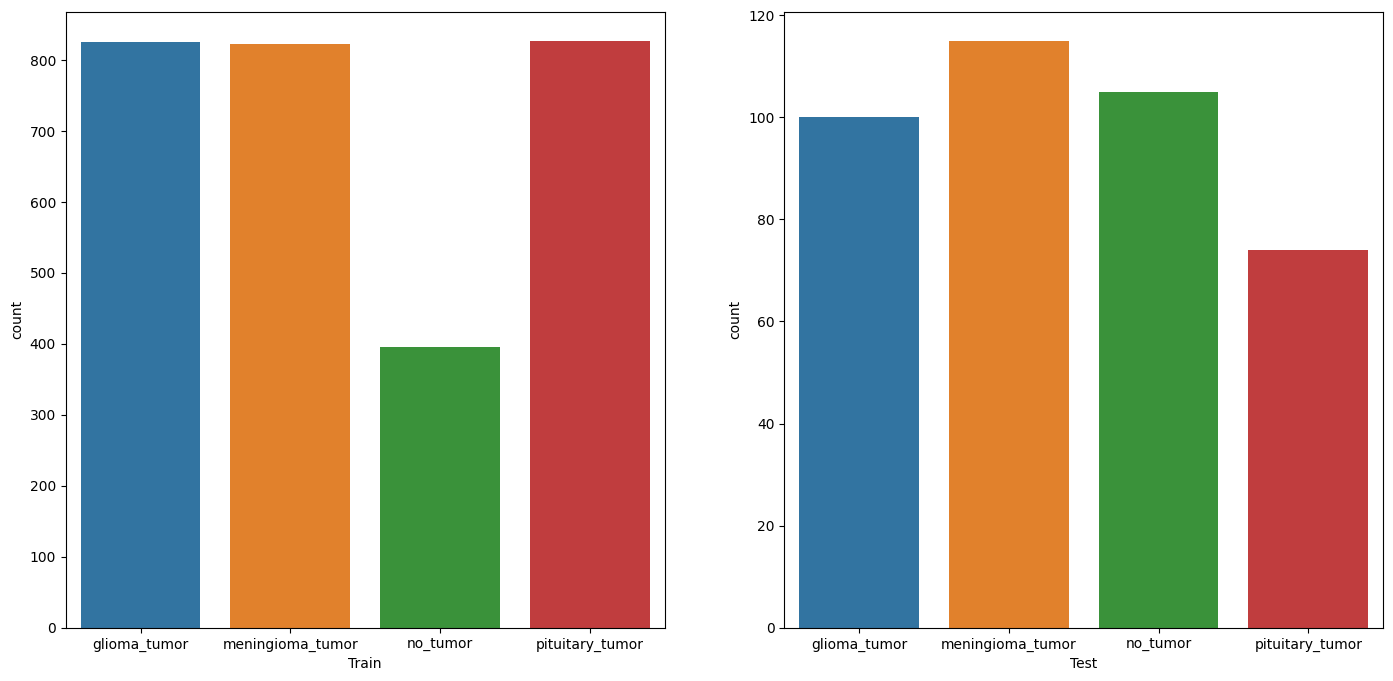

In [ ]:
plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])

En el entrenaminto los datos son equitativos, lo mismo para el caso de los datos de entrenamiento por lo que el entrenamiento se puede hacer de manera correcta.

Modelo:
Para realizar el modelo ocuparé el siguiente modelo que se puede ver en la sig arquitectura
# Hacer diag de arquitectura

In [ ]:
# modelo
model = tf.keras.Sequential([
          tf.keras.layers.Conv2D(kernel_size=(5,5) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3),filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3) ,filters=64, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(32, activation='relu'),
          tf.keras.layers.Dropout(rate=0.5),
          tf.keras.layers.Dense(16, activation='relu'),
          tf.keras.layers.Dropout(rate=0.5),
          tf.keras.layers.Dense(4, activation='softmax')
  ])

model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [ ]:
history = model.fit(train_x,train_y,validation_split=0.1, epochs =100, verbose=1, batch_size=32)


Epoch 1/100


TypeError: ignored

In [ ]:
#red creada
model.summary()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display, clear_output

train_img = []
train_labels = []

test_img = []
test_labels = []

path_train = ('/content/drive/MyDrive/Colab Notebooks/db/Training/')
path_test = ('/content/drive/MyDrive/Colab Notebooks/db/Testing/')

for i in os.listdir(path_train):
    for j in os.listdir(path_train + i):
        if j.endswith(('.jpg', '.png')):
            train_img.append(cv2.resize(cv2.imread(path_train + i + '/' + j), (150, 150)))
            train_labels.append(i)

for i in os.listdir(path_test):
    for j in os.listdir(path_test + i):
        if j.endswith(('.jpg', '.png')):
            test_img.append(cv2.resize(cv2.imread(path_test + i + '/' + j), (150, 150)))
            test_labels.append(i)

train_img = np.array(train_img) / 255.0
test_img = np.array(test_img) / 255.0

# Etiquetas
train_labels_encoded = np.array([0 if category == 'no_tumor' else (1 if category == 'glioma_tumor' else (2 if category == 'meningioma_tumor' else 3)) for category in train_labels])
test_labels_encoded = np.array([0 if category == 'no_tumor' else (1 if category == 'glioma_tumor' else (2 if category == 'meningioma_tumor' else 3)) for category in test_labels])

print("Shape of train: ", train_img.shape, " and shape of test: ", test_img.shape)

# Generador de imágenes
img_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

img_datagen.fit(train_img)
img_datagen.fit(test_img)

print("Shape of train: ", train_img.shape, " and shape of test: ", test_img.shape)

# División de datos
#train_x, val_x, train_y, val_y = train_test_split(train_img, train_labels_encoded, test_size=0.1)

# mezcla de datos
# Juntar los datos de train y test
all_img = np.concatenate((train_img, test_img))
all_labels = np.concatenate((train_labels, test_labels))

# Mezclar los datos
all_img, all_labels = shuffle(all_img, all_labels)

# Divide los datos en train y test
train_img, test_img, train_labels, test_labels = train_test_split(all_img, all_labels, test_size=0.12)

# Divide los datos de train en train y validation
train_img, val_img, train_labels, val_labels = train_test_split(train_img, train_labels, test_size=0.1)

# Modelo
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(kernel_size=(5, 5), filters=32, activation='relu', padding='same', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=32, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=32, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=32, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    #tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=32, activation='relu', padding='same'),
    #tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=32, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=64, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),


    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(68, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True) #para parar
history = model.fit(train_img, train_labels, validation_data=(val_img, val_labels), epochs=500, verbose=1, batch_size=32,callbacks=[callback])

Shape of train:  (2870, 150, 150, 3)  and shape of test:  (394, 150, 150, 3)
Shape of train:  (2870, 150, 150, 3)  and shape of test:  (394, 150, 150, 3)
Epoch 1/500


UnimplementedError: ignored

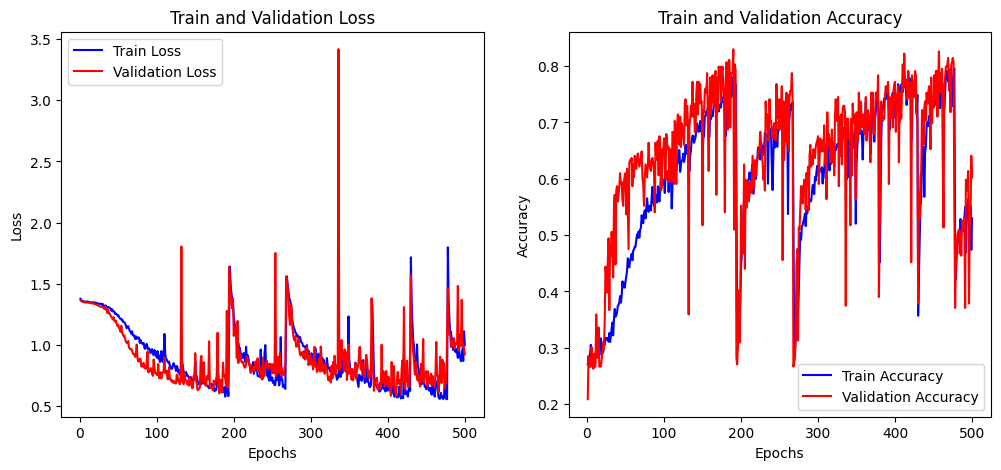

In [ ]:
import matplotlib.pyplot as plt

# Entrenamiento y validación de la pérdida
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Entrenamiento y validación de la precisión
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Número de épocas
epochs = range(1, len(train_loss) + 1)

# Gráficos de pérdida
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Train Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gráficos de precisión
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Train Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 32)        0

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display, clear_output

train_img = []
train_labels = []

test_img = []
test_labels = []

path_train = ('/content/drive/MyDrive/Colab Notebooks/db/Training/')
path_test = ('/content/drive/MyDrive/Colab Notebooks/db/Testing/')

for i in os.listdir(path_train):
    for j in os.listdir(path_train + i):
        if j.endswith(('.jpg', '.png')):
            train_img.append(cv2.resize(cv2.imread(path_train + i + '/' + j), (150, 150)))
            train_labels.append(i)

for i in os.listdir(path_test):
    for j in os.listdir(path_test + i):
        if j.endswith(('.jpg', '.png')):
            test_img.append(cv2.resize(cv2.imread(path_test + i + '/' + j), (150, 150)))
            test_labels.append(i)

train_img = np.array(train_img) / 255.0
test_img = np.array(test_img) / 255.0

# Etiquetas
train_labels_encoded = np.array([0 if category == 'no_tumor' else (1 if category == 'glioma_tumor' else (2 if category == 'meningioma_tumor' else 3)) for category in train_labels])
test_labels_encoded = np.array([0 if category == 'no_tumor' else (1 if category == 'glioma_tumor' else (2 if category == 'meningioma_tumor' else 3)) for category in test_labels])

print("Shape of train: ", train_img.shape, " and shape of test: ", test_img.shape)

# Generador de imágenes
img_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

img_datagen.fit(train_img)
img_datagen.fit(test_img)

print("Shape of train: ", train_img.shape, " and shape of test: ", test_img.shape)

# División de datos
train_x, val_x, train_y, val_y = train_test_split(train_img, train_labels_encoded, test_size=0.1)

# Modelo
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(kernel_size=(5, 5), filters=64, activation='relu', padding='same', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=64, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),


    #tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=32, activation='relu', padding='same'),
    #tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    #tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=32, activation='relu', padding='same'),
    #tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    #tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=64, activation='relu', padding='same'),
    #tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=32, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=32, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=16, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(68, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
history = model.fit(train_x, train_y, validation_split=0.1, epochs=500, verbose=1, batch_size=32)

Shape of train:  (2870, 150, 150, 3)  and shape of test:  (394, 150, 150, 3)
Shape of train:  (2870, 150, 150, 3)  and shape of test:  (394, 150, 150, 3)
Epoch 1/500
73/73 [==============================] - 15s 49ms/step - loss: 1.3771 - accuracy: 0.2874 - val_loss: 1.3744 - val_accuracy: 0.2432
Epoch 2/500
73/73 [==============================] - 3s 37ms/step - loss: 1.3662 - accuracy: 0.2930 - val_loss: 1.3723 - val_accuracy: 0.2008
Epoch 3/500
73/73 [==============================] - 3s 36ms/step - loss: 1.3592 - accuracy: 0.3012 - val_loss: 1.3627 - val_accuracy: 0.4054
Epoch 4/500
73/73 [==============================] - 3s 35ms/step - loss: 1.3500 - accuracy: 0.3335 - val_loss: 1.3649 - val_accuracy: 0.2046
Epoch 5/500
73/73 [==============================] - 2s 34ms/step - loss: 1.3496 - accuracy: 0.3021 - val_loss: 1.3620 - val_accuracy: 0.2471
Epoch 6/500
73/73 [==============================] - 3s 35ms/step - loss: 1.3451 - accuracy: 0.3133 - val_loss: 1.3599 - val_accuracy: 

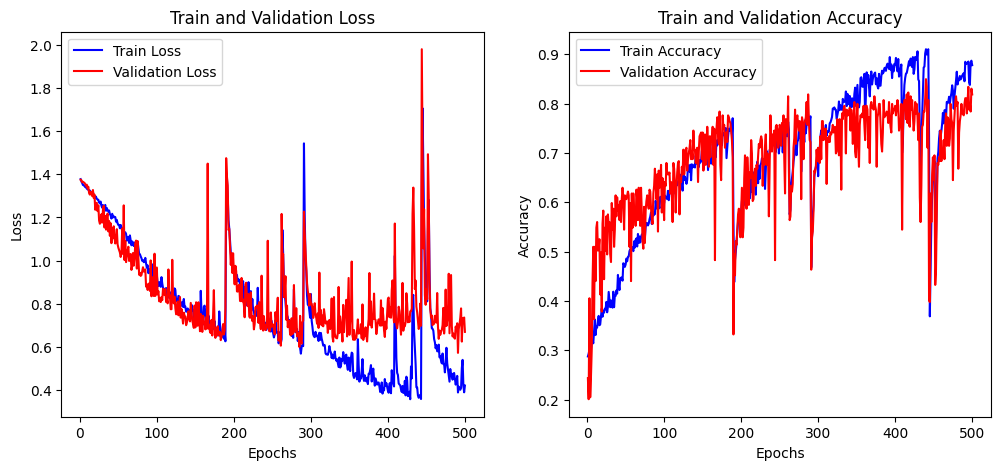

In [ ]:
#history = model.fit(train_x, train_y, validation_split=0.1, epochs=150, verbose=1, batch_size=32)
# Entrenamiento y validación de la pérdida
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Entrenamiento y validación de la precisión
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Número de épocas
epochs = range(1, len(train_loss) + 1)

# Gráficos de pérdida
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Train Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gráficos de precisión
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Train Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display, clear_output

train_img = []
train_labels = []

test_img = []
test_labels = []

path_train = ('/content/drive/MyDrive/Colab Notebooks/db/Training/')
path_test = ('/content/drive/MyDrive/Colab Notebooks/db/Testing/')

for i in os.listdir(path_train):
    for j in os.listdir(path_train + i):
        if j.endswith(('.jpg', '.png')):
            train_img.append(cv2.resize(cv2.imread(path_train + i + '/' + j), (150, 150)))
            train_labels.append(i)

for i in os.listdir(path_test):
    for j in os.listdir(path_test + i):
        if j.endswith(('.jpg', '.png')):
            test_img.append(cv2.resize(cv2.imread(path_test + i + '/' + j), (150, 150)))
            test_labels.append(i)

train_img = np.array(train_img) / 255.0
test_img = np.array(test_img) / 255.0

# Etiquetas
train_labels_encoded = np.array([0 if category == 'no_tumor' else (1 if category == 'glioma_tumor' else (2 if category == 'meningioma_tumor' else 3)) for category in train_labels])
test_labels_encoded = np.array([0 if category == 'no_tumor' else (1 if category == 'glioma_tumor' else (2 if category == 'meningioma_tumor' else 3)) for category in test_labels])


print("Shape of train: ", train_img.shape, " and shape of test: ", test_img.shape)

# Generador de imágenes
img_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

img_datagen.fit(train_img)
img_datagen.fit(test_img)

print("Shape of train: ", train_img.shape, " and shape of test: ", test_img.shape)

# transformamos las etiquetas a numeros
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
val_labels = le.fit_transform(val_labels)
test_labels = le.fit_transform(test_labels)

# otra forma de transformar las etiquetas a numeros (one hot encoding)
from keras.utils import to_categorical
train_labels = to_categorical(train_labels)
val_labels = to_categorical(val_labels)
test_labels = to_categorical(test_labels)


# mezcla de datos
# Juntar los datos de train y test
all_img = np.concatenate((train_img, test_img))
all_labels = np.concatenate((train_labels, test_labels))

# Mezclar los datos
all_img, all_labels = shuffle(all_img, all_labels)

## Divide los datos en train y test
##c, test_img, train_labels, test_labels = train_test_split(all_img, all_labels, test_size=0.1)

# Divide los datos de train en train y validation
train_img, val_img, train_labels, val_labels = train_test_split(train_img, train_labels, test_size=0.1)
# Modelo
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(kernel_size=(5, 5), filters=64, activation='relu', padding='same', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    #tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=64, activation='relu', padding='same'),
    #tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=32, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=16, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(68, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_img, train_labels, validation_data=(val_img, val_labels), epochs=500, verbose=1, batch_size=32)

Shape of train:  (2870, 150, 150, 3)  and shape of test:  (394, 150, 150, 3)
Shape of train:  (2870, 150, 150, 3)  and shape of test:  (394, 150, 150, 3)


NameError: ignored

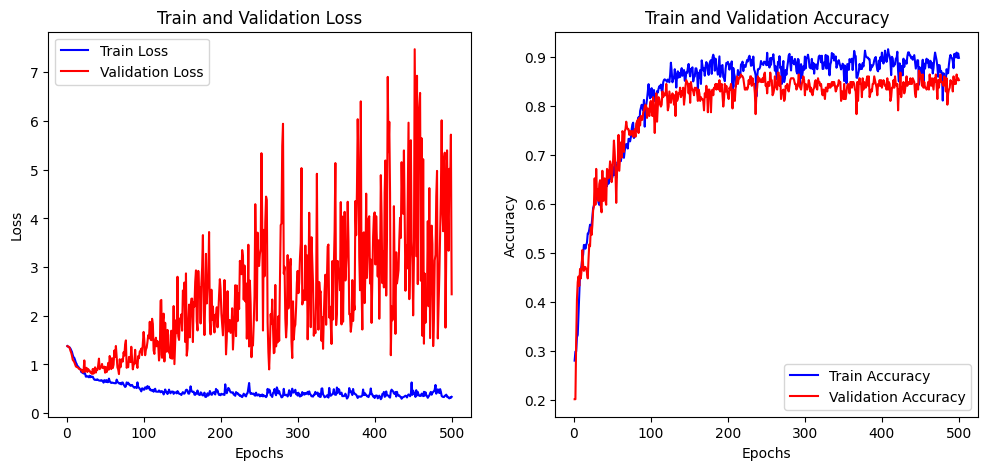

In [ ]:
#history = model.fit(train_x, train_y, validation_split=0.1, epochs=150, verbose=1, batch_size=32)
# Entrenamiento y validación de la pérdida
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Entrenamiento y validación de la precisión
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Número de épocas
epochs = range(1, len(train_loss) + 1)

# Gráficos de pérdida
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Train Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gráficos de precisión
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Train Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Comprobación de las predicciones
plt.figure(figsize=(15,15))
for i in range(9):
    random_index = np.random.randint(0, len(test_img))
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_img[random_index])
    actual_label = np.argmax(test_labels[random_index])
    predicted_label = np.argmax(predictions[random_index])
    plt.title(f'Actual: {actual_label}, Predicted: {predicted_label} with {np.max(predictions[random_index]) * 100:.2f}% confidence')
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display, clear_output

train_img = []
train_labels = []

test_img = []
test_labels = []

path_train = ('/content/drive/MyDrive/Colab Notebooks/db/Training/')
path_test = ('/content/drive/MyDrive/Colab Notebooks/db/Testing/')

for i in os.listdir(path_train):
    for j in os.listdir(path_train + i):
        if j.endswith(('.jpg', '.png')):
            train_img.append(cv2.resize(cv2.imread(path_train + i + '/' + j), (150, 150)))
            train_labels.append(i)

for i in os.listdir(path_test):
    for j in os.listdir(path_test + i):
        if j.endswith(('.jpg', '.png')):
            test_img.append(cv2.resize(cv2.imread(path_test + i + '/' + j), (150, 150)))
            test_labels.append(i)

train_img = np.array(train_img) / 255.0
test_img = np.array(test_img) / 255.0

# Etiquetas
train_labels_encoded = np.array([0 if category == 'no_tumor' else (1 if category == 'glioma_tumor' else (2 if category == 'meningioma_tumor' else 3)) for category in train_labels])
test_labels_encoded = np.array([0 if category == 'no_tumor' else (1 if category == 'glioma_tumor' else (2 if category == 'meningioma_tumor' else 3)) for category in test_labels])

print("Shape of train: ", train_img.shape, " and shape of test: ", test_img.shape)

# Generador de imágenes
img_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

img_datagen.fit(train_img)
img_datagen.fit(test_img)

print("Shape of train: ", train_img.shape, " and shape of test: ", test_img.shape)

# División de datos
train_x, val_x, train_y, val_y = train_test_split(train_img, train_labels_encoded, test_size=0.1)

# Modelo

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(kernel_size=(5, 5), filters=64, activation='relu', padding='same', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=64, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=32, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=32, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=16, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=16, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(68, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_x, train_y, validation_split=0.1, epochs=500, verbose=1, batch_size=32)

Shape of train:  (2870, 150, 150, 3)  and shape of test:  (394, 150, 150, 3)
Shape of train:  (2870, 150, 150, 3)  and shape of test:  (394, 150, 150, 3)
Epoch 1/500
73/73 [==============================] - 7s 44ms/step - loss: 1.3791 - accuracy: 0.2849 - val_loss: 1.3782 - val_accuracy: 0.2510
Epoch 2/500
73/73 [==============================] - 3s 35ms/step - loss: 1.3628 - accuracy: 0.2913 - val_loss: 1.3751 - val_accuracy: 0.2510
Epoch 3/500
73/73 [==============================] - 3s 35ms/step - loss: 1.3562 - accuracy: 0.2913 - val_loss: 1.3745 - val_accuracy: 0.2510
Epoch 4/500
73/73 [==============================] - 3s 37ms/step - loss: 1.3564 - accuracy: 0.2737 - val_loss: 1.3754 - val_accuracy: 0.2703
Epoch 5/500
73/73 [==============================] - 3s 41ms/step - loss: 1.3521 - accuracy: 0.2874 - val_loss: 1.3759 - val_accuracy: 0.2703
Epoch 6/500
73/73 [==============================] - 3s 36ms/step - loss: 1.3474 - accuracy: 0.3038 - val_loss: 1.3792 - val_accuracy: 0

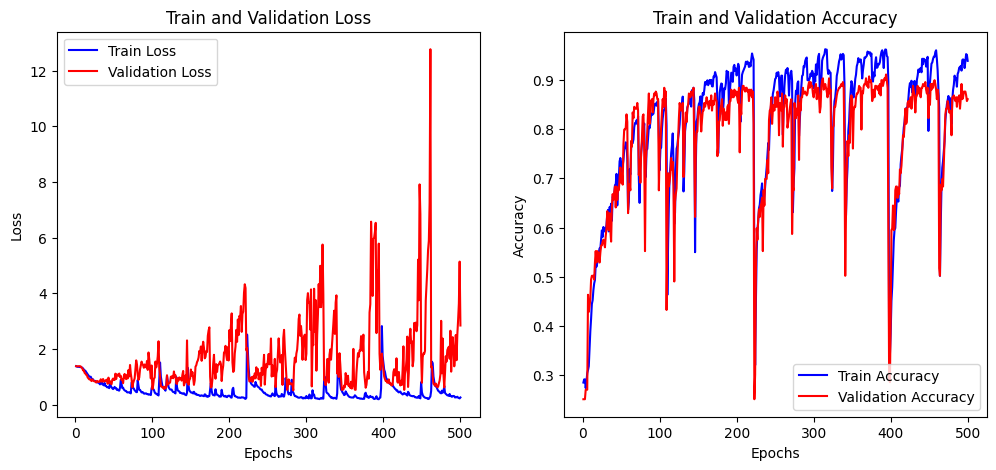

In [ ]:
#history = model.fit(train_x, train_y, validation_split=0.1, epochs=150, verbose=1, batch_size=32)
# Entrenamiento y validación de la pérdida
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Entrenamiento y validación de la precisión
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Número de épocas
epochs = range(1, len(train_loss) + 1)

# Gráficos de pérdida
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Train Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gráficos de precisión
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Train Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display, clear_output

train_img = []
train_labels = []

test_img = []
test_labels = []

path_train = ('/content/drive/MyDrive/Colab Notebooks/db/Training/')
path_test = ('/content/drive/MyDrive/Colab Notebooks/db/Testing/')

for i in os.listdir(path_train):
    for j in os.listdir(path_train + i):
        if j.endswith(('.jpg', '.png')):
            train_img.append(cv2.resize(cv2.imread(path_train + i + '/' + j), (150, 150)))
            train_labels.append(i)

for i in os.listdir(path_test):
    for j in os.listdir(path_test + i):
        if j.endswith(('.jpg', '.png')):
            test_img.append(cv2.resize(cv2.imread(path_test + i + '/' + j), (150, 150)))
            test_labels.append(i)

train_img = np.array(train_img) / 255.0
test_img = np.array(test_img) / 255.0

# Etiquetas
train_labels_encoded = np.array([0 if category == 'no_tumor' else (1 if category == 'glioma_tumor' else (2 if category == 'meningioma_tumor' else 3)) for category in train_labels])
test_labels_encoded = np.array([0 if category == 'no_tumor' else (1 if category == 'glioma_tumor' else (2 if category == 'meningioma_tumor' else 3)) for category in test_labels])

print("Shape of train: ", train_img.shape, " and shape of test: ", test_img.shape)

# Generador de imágenes
img_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

img_datagen.fit(train_img)
img_datagen.fit(test_img)

print("Shape of train: ", train_img.shape, " and shape of test: ", test_img.shape)

# División de datos
train_x, val_x, train_y, val_y = train_test_split(train_img, train_labels_encoded, test_size=0.1)

# Modelo

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(kernel_size=(5, 5), filters=64, activation='relu', padding='same', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=64, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=32, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=32, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=16, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    #tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=16, activation='relu', padding='same'),
    #tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(68, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    #tf.keras.layers.Dense(32, activation='relu'),
    #tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
history = model.fit(train_x, train_y, validation_split=0.1, epochs=500, verbose=1, batch_size=32)

Shape of train:  (2870, 150, 150, 3)  and shape of test:  (394, 150, 150, 3)
Shape of train:  (2870, 150, 150, 3)  and shape of test:  (394, 150, 150, 3)
Epoch 1/500
73/73 [==============================] - 5s 41ms/step - loss: 1.3834 - accuracy: 0.2651 - val_loss: 1.3687 - val_accuracy: 0.3629
Epoch 2/500
73/73 [==============================] - 3s 36ms/step - loss: 1.3701 - accuracy: 0.3094 - val_loss: 1.3539 - val_accuracy: 0.3861
Epoch 3/500
73/73 [==============================] - 3s 37ms/step - loss: 1.3618 - accuracy: 0.3412 - val_loss: 1.3422 - val_accuracy: 0.5097
Epoch 4/500
73/73 [==============================] - 3s 38ms/step - loss: 1.3552 - accuracy: 0.3236 - val_loss: 1.3323 - val_accuracy: 0.4093
Epoch 5/500
73/73 [==============================] - 3s 38ms/step - loss: 1.3518 - accuracy: 0.3318 - val_loss: 1.3238 - val_accuracy: 0.4903
Epoch 6/500
73/73 [==============================] - 3s 35ms/step - loss: 1.3484 - accuracy: 0.3322 - val_loss: 1.3168 - val_accuracy: 0

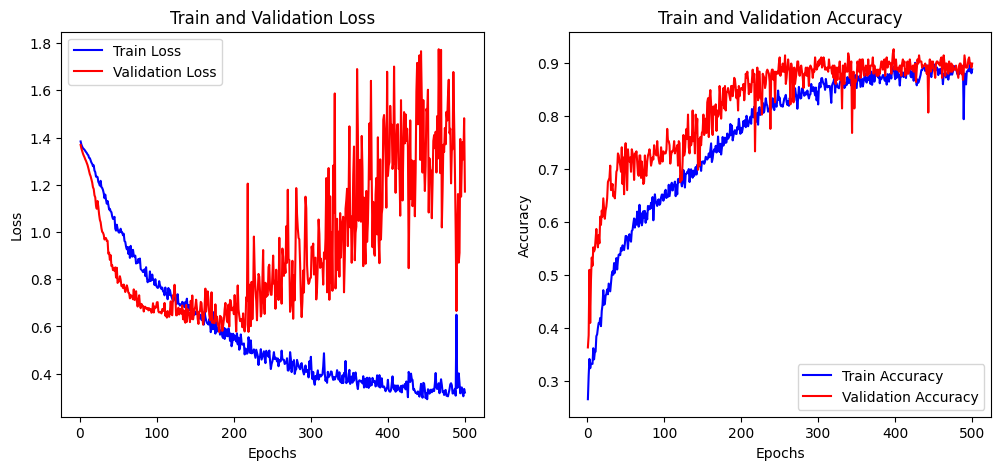

In [ ]:
#history = model.fit(train_x, train_y, validation_split=0.1, epochs=150, verbose=1, batch_size=32)
# Entrenamiento y validación de la pérdida
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Entrenamiento y validación de la precisión
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Número de épocas
epochs = range(1, len(train_loss) + 1)

# Gráficos de pérdida
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Train Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gráficos de precisión
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Train Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()